# Sensitivity to the dipole anisotropy

Here I try to create a simplified Monte-Carlo in order to test the results, published by Fermi (1903.02905v1). Especially the part where they discuss the difference between the event-shuffling and rate-based techniques.

In [1]:
from __future__ import division
import numpy as np
import healpy as hp  # need version 1.12.5 or higher
import matplotlib.pyplot as mp
from scipy.integrate import quad
from scipy.optimize import fsolve, curve_fit
from ipywidgets import FloatProgress
from IPython.display import display
import os
import pickle
import numbers
from tools import *
from astropy.coordinates.matrix_utilities import rotation_matrix

In [2]:
def get_orbit_point(full_revolutions, angspeed):
    '''
    Simulate the orbit. The output orbit is symmetric
    in equatorial coordinates. It goes from the south pole
    to the north one on constant RA with angspeed[1],
    then starts back with RA shifted by angspeed[0]
    
    Returns an array of [RA, dec] of shape (N, 2)
    '''
    ra = np.arange(0, 360 * full_revolutions, angspeed[0])
    dec = np.linspace(-90, 90, 180 / angspeed[1])
    nd = len(dec)
    ret = np.empty((nd * len(ra), 2))
    for i, _ra in enumerate(ra):
        ret[int(i * nd): int((i + 1) * nd)] = \
            np.array([np.ones(nd) * _ra, dec]).T
    return ret

In [3]:
pointing = get_orbit_point(1, [10., 10.])

/Users/stolpovs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


In [4]:
nside = 32
npix = hp.nside2npix(nside)
pointing_pix = hp.ang2pix(nside, pointing[:, 0], pointing[:, 1], lonlat=True)

In [5]:
pointing_map = np.ones(npix) * hp.UNSEEN
for ipix in xrange(npix):
    pointing_map[ipix] = (pointing_pix == ipix).sum()

/Users/stolpovs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


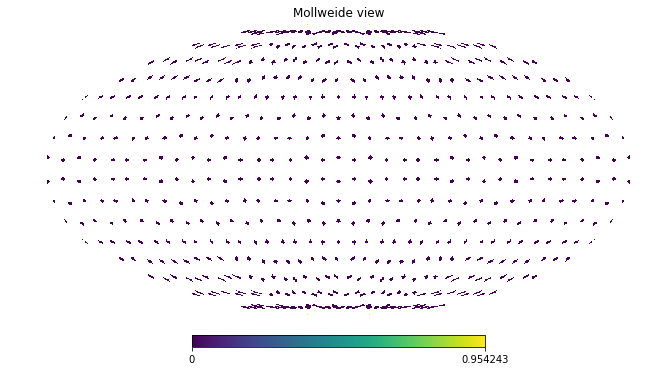

In [6]:
hp.mollview(np.log10(pointing_map))
mp.show()

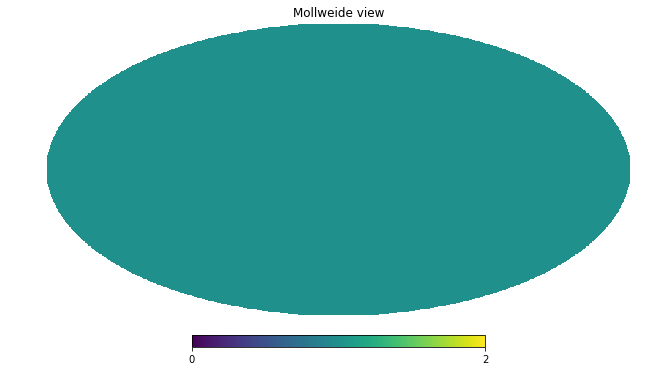

In [23]:
orig_dipole_ampl = 0.
true_dipole = create_dipole_map(nside, orig_dipole_ampl, [0, 0])
# prob -- probability to observe a particle comming from this pixel
prob = true_dipole + 1
hp.mollview(prob)
mp.show()

In [24]:
def fov(theta, phi, theta_max=60.):
    '''
    Proportional to the 2-d pdf function of the fov
    '''
    return theta < theta_max

In [25]:
def fov(theta, phi, theta_max=60.):
    '''
    Simulate the east-west effect
    '''
    r = np.random.rand(len(theta))
    return (theta < theta_max) * ((np.cos(phi) / 4 + 0.75) < r)

In [26]:
def thetaphi2radec(theta, phi, ra, dec, rotator=None):
    '''
    Transforms the satelite-based coordinates theta phi
    to the earth-based coordinates crra crdec
    (ra and dec of the cosmic ray)
    using the satelite pointing ra dec
    '''
    rot = [0., 90. - dec, -ra - 90.]

    if rotator is None:
        r = hp.Rotator(rot=rot, eulertype='X')
    else:
        r = rotator
        r._rots = [np.radians(rot)]
        r._update_matrix()
    
    theta = 90. - theta
#     crra, crdec = r(theta, phi, lonlat=True)
    crra, crdec = r(phi, theta, lonlat=True)

    if rotator is None:
        return crra, crdec, r
    return crra, crdec

### Test rotation function

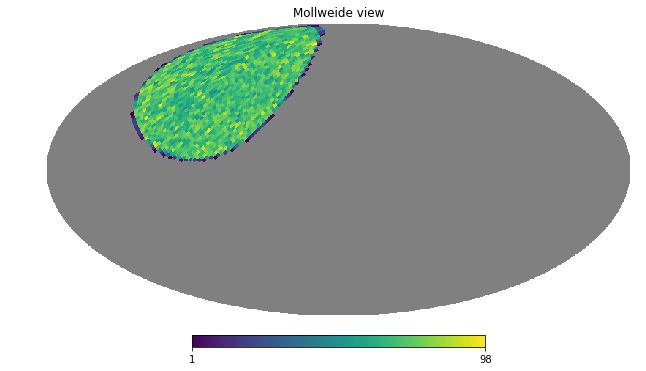

In [27]:
n = 100000

theta = np.random.rand(n) * 40.**2
theta = np.sqrt(theta)
phi = np.random.rand(n) * 360.

ra, dec = 90, 45

if not vars().has_key('rotator'):
    crra, crdec, rotator = thetaphi2radec(theta, phi, ra, dec)
else:
    crra, crdec = thetaphi2radec(theta, phi, ra, dec, rotator)
m = np.zeros(hp.nside2npix(nside))
pix = hp.ang2pix(nside, crra, crdec, lonlat=True)
for p in pix:
    m[p] += 1.
m[m == 0] = hp.UNSEEN
hp.mollview(m)

In [28]:
def instanteneous_obs(avrate, prob_map, ra, dec, fov, rotator, theta_max=60.):
    nside = hp.npix2nside(len(prob_map))
    
    coef = 10
    n = int(avrate * coef)
    theta = np.random.rand(n) * theta_max**2
    theta = np.sqrt(theta)
    phi = np.random.rand(n) * 360.
    fov_mask = fov(theta, phi, theta_max=theta_max)
    theta = theta[fov_mask]
    phi = phi[fov_mask]
    n = fov_mask.sum()
    
    crra, crdec = thetaphi2radec(theta, phi, ra, dec, rotator)

    pix_in_fov = hp.ang2pix(nside, crra, crdec, lonlat=True)
    prob = prob_map[pix_in_fov] / coef / 2.
    
    mask = np.random.rand(n) < prob
#     mask = np.random.poisson(avrate, n) < prob
    n = mask.sum()
    
    return np.ones(n) * ra, np.ones(n) * dec, theta[mask], phi[mask]

In [29]:
def simulate_obs(rate, probability_map, fov, progressbar=True):
    rot = [0., 90., - 90.]
    hp.Rotator(rot=rot, eulertype='X')

    obs = None

    if progressbar:
        progress = FloatProgress(max = len(pointing))
        display(progress)

    for p in pointing:
        io = instanteneous_obs(rate, probability_map, p[0], p[1], 
                               fov, rotator, theta_max=45.)
        if io[0] != []:
            if obs is None:
                obs = np.array(io)
            else:
                obs_new = np.empty(len(obs), dtype=object)
                for i in xrange(len(io)):
                    obs_new[i] = np.append(obs[i], io[i])
                obs = obs_new
        if progressbar:
            progress.value += 1

    obs = np.array(obs.tolist())
    return obs

In [30]:
# rate -- average event rate per time sample
rate = 1000.

obs = simulate_obs(rate, prob, fov)

FloatProgress(value=0.0, max=648.0)

/Users/stolpovs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


## Now, as the simulation is made, let's analyse it

In [31]:
def obs_to_map(nside, obs, rotator, pointing=None, progress=True):
    m = np.zeros(hp.nside2npix(nside))

    if pointing is None:
        pointing = obs[0:2].T
        
    if progress:
        pr = FloatProgress(max = len(pointing))
        display(pr)

    # divide obs in portions of equal position
    for p in pointing:
        ra, dec = p[0], p[1]
        mask = (obs[0:2].T == p).prod(axis=1).astype(bool)
#         pix = hp.ang2pix(nside, ra, dec, lonlat=True)
#         m[pix] += mask.sum()
        theta = obs[2][mask]
        phi = obs[3][mask]
        crra, crdec = thetaphi2radec(theta, phi, ra, dec, rotator)
        pix = hp.ang2pix(nside, crra, crdec, lonlat=True)
        m[pix] += 1
        if progress:
            pr.value += 1
    return m

In [32]:
obs_map = obs_to_map(nside, obs, rotator, pointing)

FloatProgress(value=0.0, max=648.0)

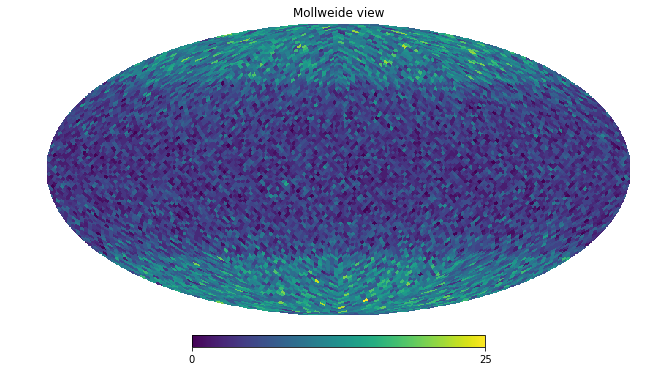

In [33]:
hp.mollview(obs_map)

### Event-shuffle

In [34]:
def shuffle_events(obs):
    i = np.arange(len(obs[0]))
    np.random.shuffle(i)
    obs[2] = obs[2][i]
    obs[3] = obs[3][i]
    return obs

In [35]:
def get_iso_map(N, obs, nside, rotator, progress=True):
    '''
    Event-shuffle method
    '''
    m = np.empty((N, hp.nside2npix(nside)))

    for i in xrange(N):
        if progress:
            print i, '...',
        shuffled = shuffle_events(obs)
        m[i] = obs_to_map(nside, shuffled, rotator, pointing=pointing, progress=False)
        if progress:
            print 'done!'
    return m.mean(axis=0)

In [19]:
iso_map = get_iso_map(20, obs, nside, rotator)

0 ... done!
1 ... done!
2 ... done!
3 ... done!
4 ... done!
5 ... done!
6 ... done!
7 ... done!
8 ... done!
9 ... done!
10 ... done!
11 ... done!
12 ... done!
13 ... done!
14 ... done!
15 ... done!
16 ... done!
17 ... done!
18 ... done!
19 ... done!


387.99871346724854

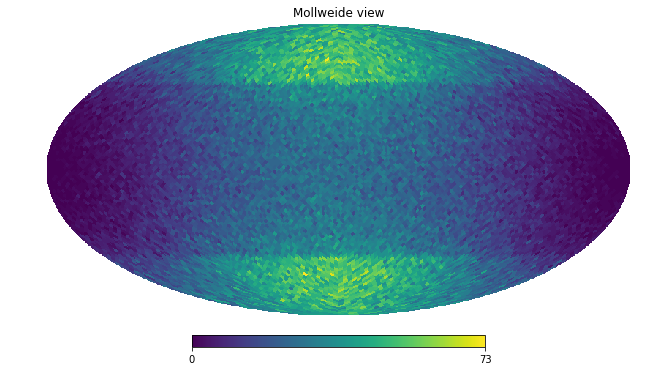

In [20]:
hp.mollview(obs_map)
hp.anafast(obs_map)[1]

148.3985409332394

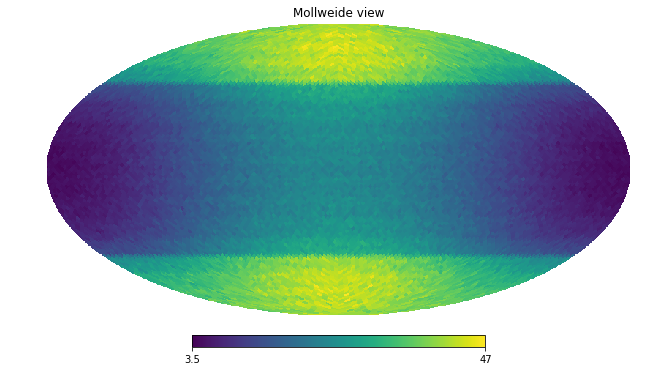

In [21]:
hp.mollview(iso_map)
hp.anafast(iso_map)[1]

In [22]:
ani_map = obs_map / iso_map - 1

In [23]:
get_dipole_ampl(ani_map)

0.446620601435414

### Noise level study (don't re-run the following cells!)

I never specify the poisson distribution of the number of events. So I wanted to check whether I do everything right. In the cells below I did the 0 dipole simulations in order to check that the noise obeys the poisson distribution.

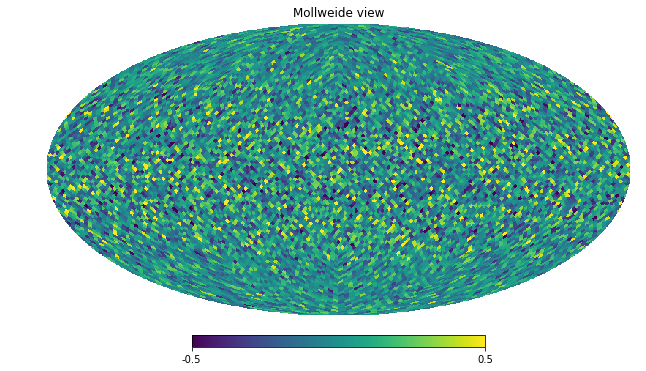

In [459]:
hp.mollview(ani_map, min=-0.5, max=0.5)

In [460]:
hp.anafast(ani_map)[1]

1.617324995137653e-05

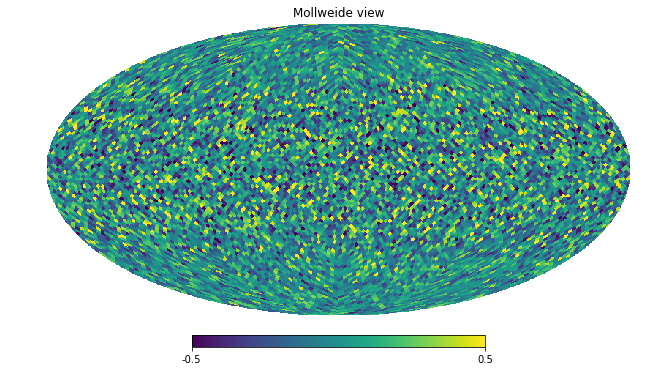

In [461]:
poisson = np.random.poisson(iso_map) / iso_map - 1
hp.mollview(poisson, min=-0.5, max=0.5)

In [462]:
dec = hp.pix2ang(nside, np.arange(npix), lonlat=True)[1]
mask = np.abs(dec) < 10.
p_poisson = poisson[mask]
p_MC = ani_map[mask]

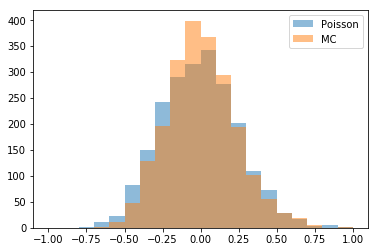

0.254
0.227


In [463]:
mp.hist(p_poisson, 20, range=(-1, 1), alpha=0.5, label='Poisson')
mp.hist(p_MC, 20, range=(-1, 1), alpha=0.5, label='MC')
mp.legend()
mp.show()

print '{:.3f}'.format(p_poisson.std())
print '{:.3f}'.format(p_MC.std())

### Run several realisations

In [120]:
def one_realisation():
    obs = simulate_obs(1000, prob, fov, progressbar=False)
#     iso_map = get_iso_map(20, obs, nside, rotator, progress=False)
    obs_map = obs_to_map(nside, obs, rotator, progress=False, pointing=pointing)
    ani_map = obs_map / iso_map - 1
    return get_dipole_ampl(ani_map)

In [122]:
N = 50

reconstructed_ampl = np.empty(N)

p = FloatProgress(max=N)
display(p)

for i in xrange(N):
    reconstructed_ampl[i] = one_realisation()
    p.value += 1

FloatProgress(value=0.0, max=50.0)

/Users/mikhailstolpovskiy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  


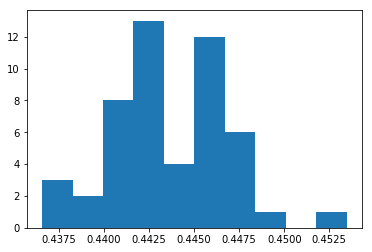

In [123]:
mp.hist(reconstructed_ampl)
mp.show()

In [124]:
reconstructed_ampl.mean()

0.44373716076449554

## Rate-based method

In [36]:
def get_iso_map(N, obs, nside, rotator, progress=True):
    '''
    Rate-based method
    '''
    m = np.empty((N, hp.nside2npix(nside)))

    for i in xrange(N):
        if progress:
            print i, '...',
        prob_local = np.ones(hp.nside2npix(nside))
        sim = simulate_obs(1000, prob_local, fov, progressbar=False)
        minlen = np.min([len(sim.T), len(obs.T)])
        sim = sim.T[:minlen].T
        ind = np.arange(minlen)
        np.random.shuffle(ind)
        sim[2] = obs[2][:minlen][ind]
        sim[3] = obs[3][:minlen][ind]
        m[i] = obs_to_map(nside, sim, rotator, pointing=pointing, progress=False)
        if progress:
            print 'done!'
    return m.mean(axis=0)

In [38]:
iso_map = get_iso_map(20, obs, nside, rotator)

 0 ...

/Users/stolpovs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


 done!
1 ... done!
2 ... done!
3 ... done!
4 ... done!
5 ... done!
6 ... done!
7 ... done!
8 ... done!
9 ... done!
10 ... done!
11 ... done!
12 ... done!
13 ... done!
14 ... done!
15 ... done!
16 ... done!
17 ... done!
18 ... done!
19 ... done!


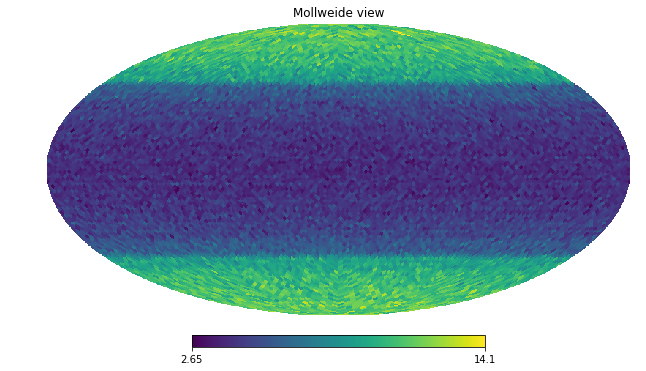

In [39]:
hp.mollview(iso_map)

0.005206462859725864
(306.9017752847134, 20.477952175029884)


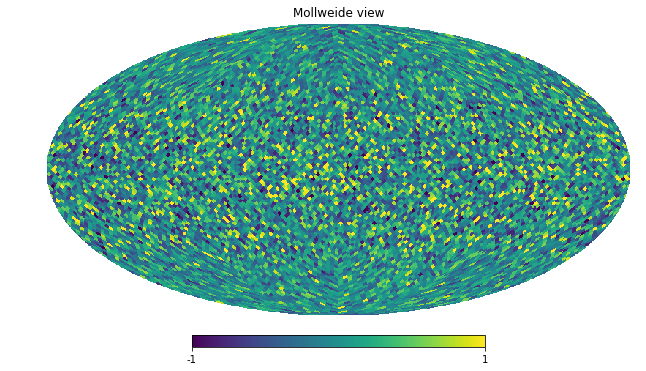

In [41]:
ani_map = obs_map / iso_map - 1
minmax = orig_dipole_ampl * 1.
hp.mollview(ani_map, min=-minmax, max=+minmax)
hp.anafast(ani_map)[1]
print get_dipole_ampl(ani_map, substract_noise=False, iso_map=iso_map)
print get_dipole_dir(ani_map)

In [112]:
def one_realisation():
    obs = simulate_obs(1000, prob, fov, progressbar=False)
#     iso_map = get_iso_map(20, obs, nside, rotator, progress=False)
    obs_map = obs_to_map(nside, obs, rotator, progress=False, pointing=pointing)
    ani_map = obs_map / iso_map - 1
    return get_dipole_ampl(ani_map)

In [113]:
N = 50

reconstructed_ampl = np.empty(N)

p = FloatProgress(max=N)
display(p)

for i in xrange(N):
    reconstructed_ampl[i] = one_realisation()
    p.value += 1

FloatProgress(value=0.0, max=50.0)

/Users/mikhailstolpovskiy/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  


KeyboardInterrupt: 

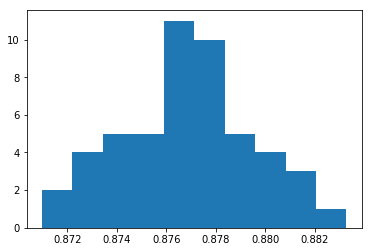

In [106]:
mp.hist(reconstructed_ampl)
mp.show()

In [107]:
print reconstructed_ampl.mean(), reconstructed_ampl.std()

0.8768493312360996 0.0026965283628353843
